# Bayesian Optimization

Usando sklearn

En 1D

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

### Funcion para Maximizar

$f(x)= x sin(x)$

In [2]:
def f(x):
    return x * np.sin(x)

### Observaciones

x son las observaciones
y son las respuestas

In [3]:
X = np.atleast_2d([1., 3.,5., 7.57,8., 9.]).T

# Observations
y = f(X).ravel()

# noise
dy = 0.001# 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise


### Gaussian Process

In [4]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha=0.1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

#Gaussian process prediction

#x = np.atleast_2d(np.linspace(0, 10, 1000)).T
#y_pred, sigma = gp.predict(x, return_std=True)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

## Acquisition Function

In [23]:
import scipy
import numpy

# upper confidence bound (UCB)
def UCB(x):
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    x1=np.array(x).reshape(-1,1)
    y_pred, sigma = gp.predict(x1, return_std=True)
    return -(y_pred + 1.96 * sigma)

# test utility function UCB
# x1 = np.atleast_2d([3])
# Y1=GPfun(x1)
# print(type(Y1))

def PI(x):
	"""
	Probability of improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 [Brochu et al. 2010])
		- epsilon: trade-off parameter (>=0)
	OUTPUT:
		- PI: probability of improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning,
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,1)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(y)
    
	Z = (muNew - fMax - epsilon)/stdNew

	return -scipy.stats.norm.cdf(Z) 


def EI(x):
	"""
	Expected improvement acquisition function
	INPUT:
		- muNew: mean of predicted point in grid
		- stdNew: sigma (square root of variance) of predicted point in grid
		- fMax: observed or predicted maximum value (depending on noise p.19 Brochu et al. 2010)
		- epsilon: trade-off parameter (>=0) 
			[Lizotte 2008] suggest setting epsilon = 0.01 (scaled by the signal variance if necessary)  (p.14 [Brochu et al. 2010])		
	OUTPUT:
		- EI: expected improvement for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	epsilon = 0.1
	x1=np.array(x).reshape(-1,1)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(y)
	Z = (muNew - fMax - epsilon)/stdNew

	return -((muNew - fMax - epsilon)* scipy.stats.norm.cdf(Z) + stdNew*scipy.stats.norm.pdf(Z))


def UCB2(x, t=X.shape[0]):
	"""
	Upper confidence bound acquisition function
	INPUT:
		- muNew: predicted mean
		- stdNew: sigma (square root of variance) of predicted point in grid
		- t: number of iteration
		- d: dimension of optimization space
		- v: hyperparameter v = 1*
		- delta: small constant (prob of regret)
		*These bounds hold for reasonably smooth kernel functions.
		[Srinivas et al., 2010]
		OUTPUT:
		- UCB: upper confidence bound for candidate point
	As describend in:
		E Brochu, VM Cora, & N de Freitas (2010): 
		A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning, 
		arXiv:1012.2599, http://arxiv.org/abs/1012.2599.
	"""
	d=1
	v=1
	delta=.1
	delta=.1
	epsilon = 0.01
	x1=np.array(x).reshape(-1,1)
	muNew, stdNew = gp.predict(x1, return_std=True)
	fMax=max(y)
	Kappa = numpy.sqrt( v* (2*  numpy.log( (t**(d/2. + 2))*(numpy.pi**2)/(3. * delta)  )))
	#print(Kappa)
	return -(muNew + Kappa * stdNew)


#test UCB function
x0 = [8]
print(-UCB2(x0))


[9.030395]


### Maximization utility function

In [24]:
from scipy.optimize import minimize
import random

x0 = np.atleast_2d([2])
n_iter=10
y_max=max(y)
bounds=np.array([0,10])
bds=[(0,10)]

fPI=0
fEI=0
fUCB=0
fUCB2=0

#bounds.shape[0]
 # Explore the parameter space more throughly
x_seeds = np.random.uniform(bounds[0], bounds[1],
                                   size=(n_iter, 1))

#print(bounds.shape[0])
for x_try in x_seeds:
        # Find the minimum of minus the acquisition function
 #       print(x_try)
        res_PI=minimize(fun=PI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_EI=minimize(fun=EI,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB=minimize(fun=UCB,x0=x_try,method="L-BFGS-B",bounds=bds)
        res_UCB2=minimize(fun=UCB2,x0=x_try,method="L-BFGS-B",bounds=bds)
        
#         Store it if better than previous minimum(maximum).
        if fPI is None or  -res_PI.fun[0] >= fPI:
            x_PI_max = res_PI.x
            fPI = -res_PI.fun[0]
        if fEI is None or -res_EI.fun[0] >= fEI:  
            x_EI_max = res_EI.x
            fEI = -res_EI.fun[0]
        if fUCB is None or -res_UCB.fun[0] >= fUCB:   
            x_UCB_max = res_UCB.x        
            fUCB = -res_UCB.fun[0]
        if fUCB2 is None or -res_UCB2.fun[0] >= fUCB2:  
            x_UCB2_max = res_UCB2.x
            fUCB2 = -res_UCB2.fun[0]
            
            

print ("X PI:")
print (x_PI_max) 
print ("X EI:")
print (x_EI_max)
print ("X UCB:")
print (x_UCB_max)
print ("X UCB2:")
print (x_UCB2_max)
# print ("UCB:")
# print (max_acq)

X PI:
[7.94465091]
X EI:
[7.97198035]
X UCB:
[8.00763526]
X UCB2:
[10.]


Text(0, 0.5, 'PI')

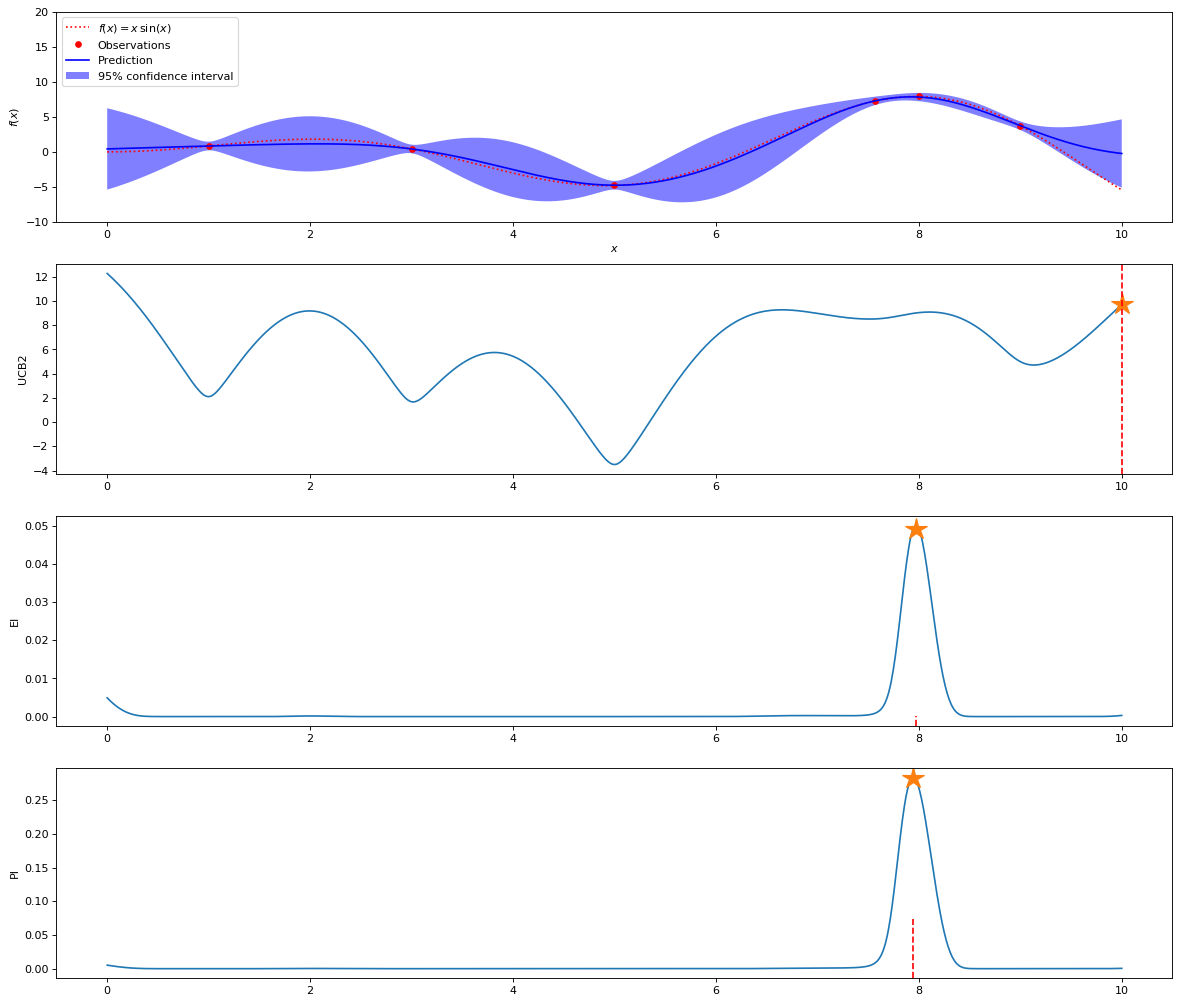

In [28]:
# ploting

x = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(18, 16), dpi= 80)
plt.subplot(4,1,1)
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(x,-UCB2(x))
plt.plot(x_UCB2_max, -UCB2(x_UCB2_max),'*',markersize=20)
plt.axvline(x=x_UCB2_max,ymin=0, ymax= -UCB2(x_UCB2_max), color='red',linestyle='--')
plt.ylabel('UCB2')

plt.subplot(4,1,3)
plt.plot(x,-EI(x))
plt.plot(x_EI_max, -EI(x_PI_max),'*',markersize=20)
plt.axvline(x=x_EI_max,ymin=0, ymax=-EI(x_EI_max), color='red',linestyle='--')
plt.ylabel('EI')

plt.subplot(4,1,4)
plt.plot(x,-PI(x))
plt.plot(x_PI_max,-PI(x_PI_max),'*',markersize=20)
plt.axvline(x=x_PI_max,ymin=0, ymax=-PI(x_PI_max), color='red',linestyle='--')
plt.ylabel('PI')

# print ("Next X")
# print (x_max) 
# print ("Max posible predicted")       
# print (max_acq)